In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

/home/lukas/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model and tokenizer
model_name = 'SamLowe/roberta-base-go_emotions'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
model.eval()

/home/lukas/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [3]:
# Load the dataset
dataset = load_dataset('go_emotions')

# Select a subset of 2000 samples from the 'train' split
subset_size = 8000
data = dataset['train'].shuffle(seed=42).select(range(subset_size))

In [4]:
# Extract texts and labels
texts = data['text']
labels = data['labels']  # Multi-labels (list of lists)

In [5]:
# Simplify labels to the first label
single_labels = [label[0] if label else -1 for label in labels]

# Filter out samples without labels
filtered_texts = [text for text, label in zip(texts, single_labels) if label != -1]
filtered_labels = [label for label in single_labels if label != -1]

print(f"Number of samples after filtering: {len(filtered_texts)}")

Number of samples after filtering: 8000


In [6]:
filtered_texts

['I would say they do because it was a horrible accident but they were also in the wrong. The military tried to get them to disperse they didnt.',
 'Done, good luck with your thing.',
 'Now, this is epic! ',
 'Eat better.',
 'So you stay on your theft from auto waiting for them to dispatch the next shift to the backlog of calls.',
 "Glad to hear it's ubiquitous and not an OS thing.",
 'Now we’re wishing death on 15 year old kids? Keep setting the bar lower please',
 'Oh so it is a separate guy filming, it’s actually impressive how synced up their speeds are',
 "Yes. I got accused of being a man or a bootlicker because I was a mod in a men's lib sub two years ago.",
 'Get big, whatever it takes.',
 'It’s amazing what they can justify to themselves. I’m not sure if I can believe anything out of her mouth anymore.',
 "Calm down. It's a real concept.",
 'Wow, what a controversial opinion.',
 "If I have to watch Canada lose in a shootout I'm gonna lose it",
 'what time is it now? i’m defini

In [7]:
def get_embeddings(text_list, tokenizer, model):
    embeddings = []
    batch_size = 16 
    check = batch_size*20
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
            outputs = model(**inputs, output_hidden_states=True)

            hidden_states = outputs.hidden_states  # Tuple of tensors

            # Use the last hidden state
            last_hidden_state = hidden_states[-1]  # Shape: (batch_size, seq_length, hidden_size)

            # Mean pooling
            attention_mask = inputs['attention_mask'].unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            masked_hidden_state = last_hidden_state * attention_mask
            sum_embeddings = torch.sum(masked_hidden_state, dim=1)
            sum_mask = torch.sum(attention_mask, dim=1)
            embedding = sum_embeddings / sum_mask  # Shape: (batch_size, hidden_size)

            embeddings.append(embedding)
            if i % check == 0:
                print(f"Processed {i + len(batch_texts)}/{len(text_list)} samples")
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings


In [8]:
embeddings = get_embeddings(filtered_texts, tokenizer, model)
print(f"Embeddings shape: {embeddings.shape}")

Processed 16/8000 samples
Processed 336/8000 samples
Processed 656/8000 samples
Processed 976/8000 samples
Processed 1296/8000 samples
Processed 1616/8000 samples
Processed 1936/8000 samples
Processed 2256/8000 samples
Processed 2576/8000 samples
Processed 2896/8000 samples
Processed 3216/8000 samples
Processed 3536/8000 samples
Processed 3856/8000 samples
Processed 4176/8000 samples
Processed 4496/8000 samples
Processed 4816/8000 samples
Processed 5136/8000 samples
Processed 5456/8000 samples
Processed 5776/8000 samples
Processed 6096/8000 samples
Processed 6416/8000 samples
Processed 6736/8000 samples
Processed 7056/8000 samples
Processed 7376/8000 samples
Processed 7696/8000 samples
Embeddings shape: torch.Size([8000, 768])


In [9]:
embeddings.shape

torch.Size([8000, 768])

In [10]:
embeddings_normed = embeddings/torch.norm(embeddings, dim = 1, keepdim=True)
embeddings_np = embeddings_normed.cpu().numpy()

In [11]:
embe = embeddings.numpy()
mean_vector = np.mean(embe, axis=0)
embeddings_centered = embe - mean_vector

In [12]:
# save the embeddings
# np.save('embeddings_full.npy', embeddings_np)
# embeddings_np = np.load('embeddings.npy')
# np.save('embeddings_centered_full.npy', embeddings_centered)
# embeddings_centered = np.load('embeddings_centered_full.npy')

In [13]:
embeddings_np.shape, embeddings_np

((8000, 768),
 array([[-0.02826293, -0.00594943, -0.01307897, ...,  0.02817439,
         -0.02378688, -0.03669343],
        [-0.01639233,  0.0104459 , -0.04259222, ..., -0.05218633,
         -0.00535237,  0.01488838],
        [ 0.01357459, -0.03743499, -0.02880043, ...,  0.0378496 ,
         -0.00137202,  0.00439016],
        ...,
        [-0.03007842,  0.00818375,  0.01455516, ..., -0.0595521 ,
         -0.01490583, -0.02699503],
        [-0.0188288 ,  0.00561057, -0.01218958, ..., -0.00745485,
          0.01244315, -0.0315602 ],
        [-0.05211419, -0.00674763, -0.04644689, ...,  0.01793253,
         -0.0004112 , -0.03454848]], dtype=float32))

Here I guess we would need spherical PCA. Normalization and playning on Euclidean space doesn't bring anything so one really needs some factors over sphere?

In [14]:
from sklearn.decomposition import PCA

n_components = 40  # Number of components to keep

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(embeddings_np)
print(f"Principal components shape: {principal_components.shape}")

Principal components shape: (8000, 40)


In [15]:
explained_variance = pca.explained_variance_ratio_
sumvar = 0
for i, var in enumerate(explained_variance):
    sumvar += var
    print(f'PC{i+1} explains {var*100:.2f}% of the variance, total explained variance: {sumvar*100:.2f}%')

PC1 explains 13.99% of the variance, total explained variance: 13.99%
PC2 explains 9.98% of the variance, total explained variance: 23.97%
PC3 explains 8.49% of the variance, total explained variance: 32.46%
PC4 explains 6.82% of the variance, total explained variance: 39.28%
PC5 explains 5.68% of the variance, total explained variance: 44.96%
PC6 explains 5.39% of the variance, total explained variance: 50.35%
PC7 explains 5.02% of the variance, total explained variance: 55.37%
PC8 explains 4.26% of the variance, total explained variance: 59.63%
PC9 explains 3.86% of the variance, total explained variance: 63.49%
PC10 explains 3.74% of the variance, total explained variance: 67.23%
PC11 explains 3.32% of the variance, total explained variance: 70.55%
PC12 explains 3.06% of the variance, total explained variance: 73.61%
PC13 explains 2.51% of the variance, total explained variance: 76.12%
PC14 explains 2.08% of the variance, total explained variance: 78.20%
PC15 explains 1.94% of the v

As expectred, the model uses much more idms here as sentiment score model, just because he can and needs to give 27 dim classification not just one scalar. 

Text(0.5, 1.0, 'UMAP embedding')

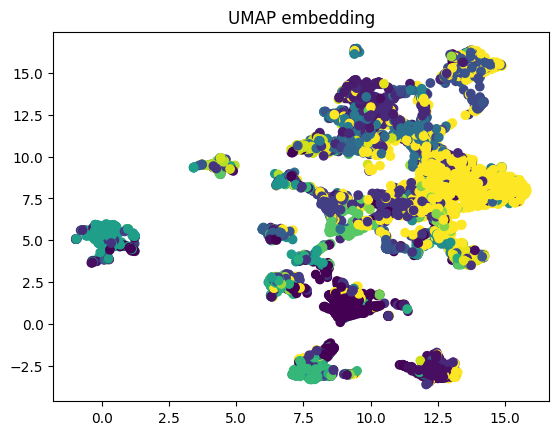

In [18]:
import umap.umap_ as umap

sphere_mapper = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine').fit(embeddings_np)
plt.scatter(sphere_mapper.embedding_[:,0], sphere_mapper.embedding_[:,1], c=filtered_labels)
plt.title('UMAP embedding')

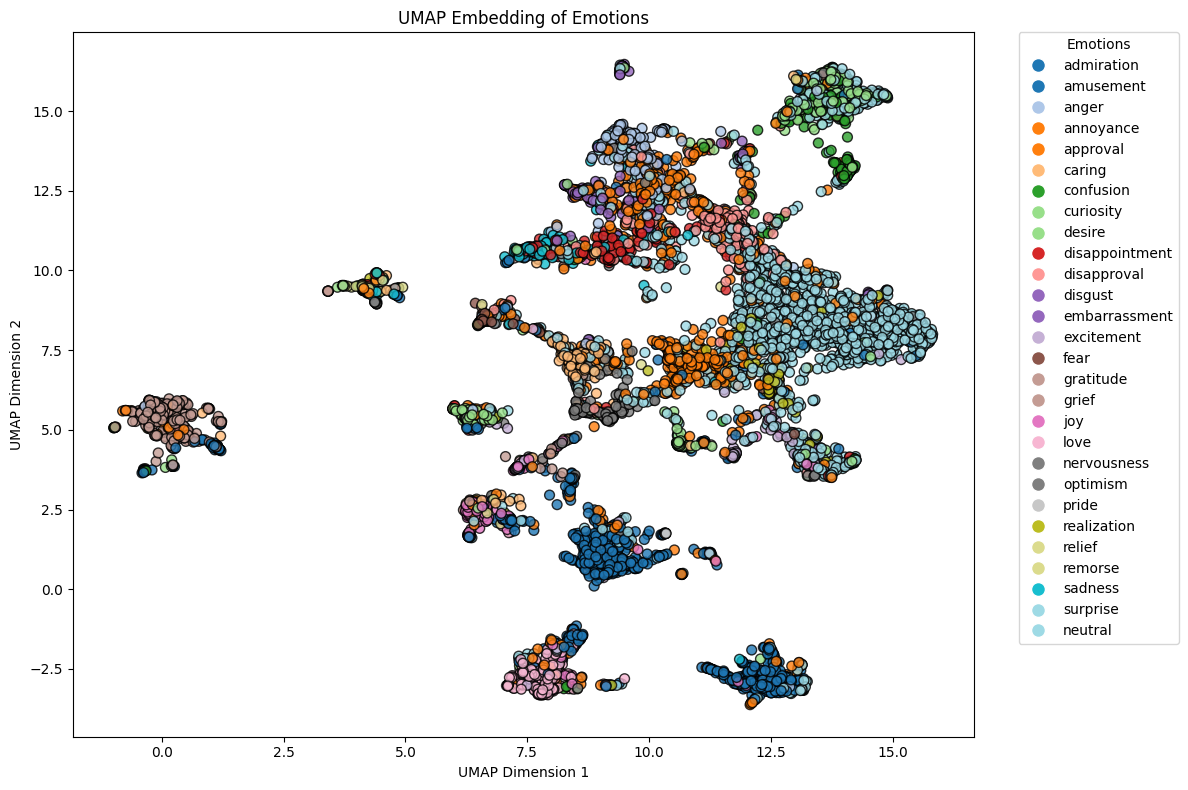

In [19]:
emotion_names = dataset['train'].features['labels'].feature.names

unique_labels = np.unique(filtered_labels)
cmap = plt.get_cmap('tab20', len(unique_labels))  

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    sphere_mapper.embedding_[:, 0],
    sphere_mapper.embedding_[:, 1],
    c=filtered_labels,
    cmap=cmap,
    alpha=0.8,
    edgecolor='k',
    s=50
)

# Create a custom legend using color mapping
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10)
    for i in range(len(unique_labels))
]
plt.legend(handles, [emotion_names[i] for i in unique_labels], title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Set title and axis labels
plt.title('UMAP Embedding of Emotions')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.show()
